# Variational Quantum Eigensolver using OpenFermion package

In this tutorial we build a Variational Quantum Eigensolver (VQE), using Qmod and OpenFermion package [[1](#OF)]. The basic usage of this quantum chemistry package is incorporated in the notebook, however, we encourage the reader to read the [into tutorial](https://quantumai.google/openfermion/tutorials/intro_to_openfermion) of this package [[2](#OFintro)].

## Defining a molecule

We start with defining a molecule, specifying its geometry (elements and their 3D position), multiplicity ($2\cdot(\text{total spin})+1$), basis, and an optional string for its description. In this tutorial we focus on the LiH molecule.

In [1]:
# !pip install openfermion
# !pip install openfermionpyscf

In [2]:
from openfermion.chem import MolecularData

# Set up molecule parameters
basis = "sto-3g"  # Basis set
multiplicity = 1  # Singlet state S=0
charge = 0  # Neutral molecule

geometry = [("H", (0.0, 0.0, 0.0)), ("Li", (0, 0.0, 1.596))]
description = "LiH"

# Create MolecularData object
molecule = MolecularData(geometry, basis, multiplicity, charge, description)

Next, we run a pyscf plugin for calculating various objects for our molecule problem, such as the second quantized Hamiltonian that is at the core of the VQE algorithm. For small problems, we can also get the Full Configuration Interaction (FCI), which calculates classically the ground state energy, i.e., for validating our quantum approach.

**Comment:** For complex problems running pyscf can take time, it is possible to run it only once, and load the data later on, using the `save` and `load` methods.

In [3]:
from openfermionpyscf import run_pyscf

RUN_PYSCF = True  # can be set to False after initial run
if RUN_PYSCF:
    molecule = run_pyscf(
        molecule,
        run_mp2=True,
        run_cisd=True,
        run_ccsd=True,
        run_fci=True,  # relevant for small, classically solvable problems
    )
    molecule.save()

molecule.load()

Now we can get several properties of our molecular problem. The electronic structure problem is described as a second quantized Hamiltonian
$$
\Large H = h_0 + \sum_{p,q=0}^{2N-1} h_{pq}\, a^\dagger_p a_q + \frac{1}{2} \sum_{p,q,r,s=0}^{2N-1} h_{pqrs} \, a^\dagger_p a^\dagger_q a_r a_s,
\tag{1}
$$
where $h_0$ is a constant nuclear repulsion energy, and $h_{pq}$ and $h_{pqrs}$ are the well-known one-body and two-body molecular integrals, respectively. We can access these objects calling `molecule.nuclear_repulsion`,  `molecule.one_body_integrals` and `molecule.two_body_integrals`. The sum is over all spin orbitals, which is twice the number of spatial orbitals $N$, as for each spatial orbital we have a spin up and spin down space (also known as alpha and beta particles). This, together with the number of free electrons that can occupy those orbitals, defines the electronic structure problem.

In [4]:
n_spatial_orbitals = molecule.n_orbitals
n_electrons = molecule.n_electrons
print(
    f"The electronic structure problems has {2*n_spatial_orbitals} spin orbitals, and we need to occupy {n_electrons} electrons"
)

The electronic structure problems has 12 spin orbitals, and we need to occupy 4 electrons


## Defining a Fermionic operator for a reduced problem (active space/freeze core)

In some cases, we can "freeze" some of the orbitals, occuping them with both spin up and spin down electrons. In other words, we can choose the active space for our molecular problem --- the spatial orbitals that are relevant to the quantum problem. This of-course reduces the problem we need to tackle. Below we freeze the core ($0^{\rm th}$) orbital, and define the Fermionic operator object (as in Eq. (1)). Note that we have to update the number of spatial orbitals and electrons accordingly.

In [5]:
from openfermion.transforms import get_fermion_operator

# Get the Hamiltonian in an active space
first_active_index = 1
last_active_index = n_spatial_orbitals
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(first_active_index),  # freezing the core
    active_indices=range(
        first_active_index, last_active_index
    ),  # active space is all the rest of the orbitals
)

## Update the number of orbitals and electrons
n_freezed_orbitals = first_active_index + n_spatial_orbitals - last_active_index
n_spatial_orbitals -= n_freezed_orbitals
n_electrons -= 2 * n_freezed_orbitals
print(f"Reduced number of spatial orbitals after freeze core: {n_spatial_orbitals}")
print(f"Reduced number of electrons after freeze core: {n_electrons}")


# Map operator to fermions
fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
fermion_hamiltonian.compress(abs_tol=1e-13)  # trimming
n_qubits = molecular_hamiltonian.n_qubits
print(
    f"Length of Hamiltonian in Fermionic representation: {len(fermion_hamiltonian.terms)}"
)
print(f"Number of qubits representing the problem: {n_qubits}")

Reduced number of spatial orbitals after freeze core: 5
Reduced number of electrons after freeze core: 2
Length of Hamiltonian in Fermionic representation: 811
Number of qubits representing the problem: 10


Let us look at several terms of our Fermionic operator:

In [6]:
print(*list(fermion_hamiltonian.terms.items())[:5], sep="\n")
print(*list(fermion_hamiltonian.terms.items())[::-1][:5], sep="\n")

((), -6.803181810768873)
(((0, 1), (0, 0)), -0.7731996579740227)
(((0, 1), (2, 0)), 0.048511871711463865)
(((0, 1), (8, 0)), -0.12700068949786045)
(((1, 1), (1, 0)), -0.7731996579740227)
(((9, 1), (9, 1), (9, 0), (9, 0)), 0.22696229248056873)
(((9, 1), (9, 1), (9, 0), (3, 0)), -0.022028595906848865)
(((9, 1), (9, 1), (9, 0), (1, 0)), 0.06723206709609772)
(((9, 1), (9, 1), (7, 0), (7, 0)), 0.009857624022738895)
(((9, 1), (9, 1), (5, 0), (5, 0)), 0.009857624022738896)


We can see one-body terms $((i,1),(j,0))$ that refer to $a_i^{\dagger}a_j$, and two-body terms $((i,1),(j,1),(k,0),(l,0))$ that corresponds to $a_i^{\dagger}a_j^{\dagger}a_ka_l$.

<div style="background-color:#f0f8ff; border-left: 5px solid #0077cc; padding: 10px;">
<strong> Orbital labeling: :</strong> For $N$ spatial orbitals we have $N_\alpha (\text{spin up})=N_\beta (\text{spin down})=N$. In OpenFermion, the order of spin orbitals is alternating spin labeling $(0_\uparrow, 0_\downarrow, 1_\uparrow, 1_\downarrow,\dots, (N-1)_\uparrow, (N-1)_\downarrow$). When transforming the problem to a Qubit Hamiltonian, described by Pauli strings, then different ordering can results in different Hamiltonians, which in turn, might  lead to different quantum circuits in terms of depth or cx-counts. For example, Classiq's built-in `MoleculeProblem` object is defined according to block spin labeling $(0_\uparrow, 1_\uparrow, \dots, (N-1)_\uparrow, 0_\downarrow,1_\downarrow\dots, (N-1)_\downarrow$).
</div>


## Transforming to Qubit Hamiltonian (Pauli strings)

Next, we need to transform the creation/annihilation operators to Pauli operators, suitable for quantum algorithms. There are several known transforms, such as Jordan Wigner (JW) and Bravyi Kitaev (BK) transforms. In this tutorial we will use the JW transform.

In [7]:
from openfermion.transforms import jordan_wigner

qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
qubit_hamiltonian.compress(abs_tol=1e-13)  # trimming

print(f"Length of Hamiltonian in Pauli representation: {len(qubit_hamiltonian.terms)}")
print("Example of Pauli Hamiltonian terms:")
print(*list(qubit_hamiltonian.terms.items())[:5], sep="\n")

Length of Hamiltonian in Pauli representation: 276
Example of Pauli Hamiltonian terms:
((), -5.733275537578996)
(((0, 'Z'),), -0.2985805350598836)
(((0, 'Y'), (1, 'Z'), (2, 'Y')), -0.0036135212781293023)
(((0, 'X'), (1, 'Z'), (2, 'X')), -0.0036135212781293023)
(((0, 'Y'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'Z'), (5, 'Z'), (6, 'Z'), (7, 'Z'), (8, 'Y')), -0.012932087092919691)


### Hartree Fock state

The Hartree Fock state refers to excitation of all the lower energy orbitals. In OpenFermion notation, these refer to the lowest orbital indices. Thus, if we have $M$ free electrons, we just excite the first $M$ states. This is captured by operating on the zero state with the operator
$$
H_{\rm HF} = \sum^{M}_{i=0} a^{\dagger}_{i}.
$$

In [8]:
from openfermion import FermionOperator

hf_excitation = FermionOperator(" ".join(f"{o}^" for o in range(n_electrons)), 1.0)
hf_operator = jordan_wigner(hf_excitation)
hf_operator.compress(1e-13)

Typically, e.g., for the Jordan Wigner or the Bravyi Kitaev transforms, the Hartree Fock state, which is an elementary basis state in the Fock space, is mapped to a single computational basis state. Below we define a function that calculates the mapped Hartree Fock state, by operating on the zero state.

In [9]:
def get_mapped_hf_state(hf_operator, n_qubits):
    # Return the operation of a QubitOperator on the zero state
    states = {}
    for term, coefficient in hf_operator.terms.items():
        state = [0] * n_qubits
        coe = coefficient
        for op in term:
            if op[1] == "X":
                state[op[0]] ^= 1
            if op[1] == "Y":
                state[op[0]] ^= 1
                coe *= 1j
        state = "".join(map(str, state))
        states[state] = states.get(state, 0) + coe
    if len(states) > 1:
        raise ValueError(f"The resulting HF state is not a single QNum, got {states}")
    return list(states.keys())[0]


hf_str = get_mapped_hf_state(hf_operator, n_qubits)
print(f"The HF state: {hf_str}")

The HF state: 1100000000


<div style="background-color:#f0f8ff; border-left: 5px solid #0077cc; padding: 10px;">
<strong> HF state under the JW transform: :</strong> Working with the JW transform, there is a simple relation between the original Fock (occupation number) and transformed (computational) basis states: the state $|\underbrace{0\dots 0}_{k-1}10\dots 0\rangle$ corresponds to occupation of the $k$-th spin orbital in both spaces. Therefore, the Hartree Fock state under this transformation is a string that startes with `n_electrons` 1s, and the rest is 0.
</div>


## Reducing the problem size with $\mathbb{Z}_2$ symmetries (qubit tapering)

Next, we will use symmetries to reduce the problem size. The theory of qubit tapering is broad and complex, see for example Refs [[3](#sym1)] and [[4](#sym2)]. The main steps of this procedure are as follows:

1. Find generators $\left\{g^{(i)}\right\}^k_{i=1}$ for a group of operators that commute with the Hamiltonian $H$: for all $g\in \langle g^{(1)},\dots g^{(k)}\rangle$, $\left[H, g\right] = 0$. That means that there is a basis in which both $H$ and such $g$ operators are diagonal. These operators are assumed to be a single Pauli string, typically containing only Pauli $Z$ operators.
2. Find a unitary transformation $U$ that diagonalizes all $g^{(i)}$, such that each generator operates trivially on all qubits except one, e.g., they transform to operators of the form $X_{l}$ for some qubit number $l$. It can be shown that such unitary can be constructed as $\Pi^k_{i=1}\frac{1}{\sqrt{2}}\left(X_{m^{(i)}}+g^{(i)}\right)$, where $X_{m^{(i)}}$ is operating on a some single qubit $m^{(i)}$.
3. Apply the transformation $U^{\dagger} H U$, whose eigenspace will be identical to those of $U^{\dagger} g_i U$. That means that on some qubits the transformed Hamiltonian is acting trivially, returning $\pm 1$ (thus is the name $\mathbb{Z}_2$ symmetries), and we can taper them off.
4. Taper off qubits from the transformed Hamiltonian.

### Step 1: Finding generators for the symmetry group $\left\{g^{(i)}\right\}$ and their accompanying $\left\{X_{m^{(i)}}\right\}$ operators

There are known techniques for finding a set of independent $\mathbb{Z}_2$-symmetry generators, see Refs [[3](#sym1)] and [[4](#sym2)]. In the Appendix of this tutorial we provide a code that implements a function, `find_z2sym`, for obtaining $\left\{\left(g^{(i)}, X_{m^{(i)}}\right)\right\}$ for a given Hamiltonian. Instead of working with the generic approach, in this tutorial we will use some educated guess, according to some physical properties--- conservation laws--- of our system, to define several symmetry operations. In electronic structure problems we have, for example, **particle number conservation**, **spin conservation**, and **number of particles with fixed spin orientation**. The latter corresponds to the two Fermionic operators:
$$
\text{Total number of spin-up/down particles operator:} \qquad \hat{N}_{\uparrow} = \sum_i a^{\dagger}_{i\uparrow} a_{i\uparrow}, \qquad 
\hat{N}_{\downarrow} = \sum_i a^{\dagger}_{i\downarrow} a_{i\downarrow}.
$$
We can use this conserved quantities to construct some relevant symmetry generators, when working with the JW transform: 
$$
g_{\uparrow} = \Pi^{N/2}_{k=0}Z_{2k}, \qquad g_{\downarrow} = \Pi^{N/2}_{k=0}Z_{2k+1}.
$$
For more details see the info box below (note that using the generic approach given in the Appendix, one finds 4 symmetry generators. See last code block at the bottom of the notebook).

<div style="background-color:#f0f8ff; border-left: 5px solid #0077cc; padding: 10px;">
<strong> Conserved quantities under the JW transform: :</strong> As explained in the previous info box, working with the JW transform gives that Fock basis state are trasformed to the computational basis states. In particular, there is a relation between the orbital number operator and the $Z$ operators: $n_i = a_i^{\dagger}a_i = \frac{1}{2}\left(1-Z_i\right)$. We cannot use the transformation of $N_{\uparrow(\downarrow)}$ as our symmetry generators, as it corresponds to a sum of Pauli strings rather than a single string. However, we can use any function of those, for example $g_{\uparrow(\downarrow)} = e^{\pi i S_{\uparrow(\downarrow)}}$, which, up to a global phase, gives the generators chosen above.
</div>


Let us define and verify our generators and verify their commutation relation with the Hamiltonian:

In [10]:
from openfermion import QubitOperator
from openfermion.utils import commutator

## Total number operator
up_number_generator = QubitOperator(
    tuple([(2 * k, "Z") for k in range(n_qubits // 2)]), 1.0
)
up_number_generator.compress(1e-13)
print("Up number generator:")
print(*up_number_generator, sep="+")
print(
    f"Norm of commutator with the Hamiltonian {commutator(qubit_hamiltonian, up_number_generator).induced_norm(1)}"
)
print("=" * 40)

## S_z operator
down_number_generator = QubitOperator(
    tuple([(2 * k + 1, "Z") for k in range(n_qubits // 2)]), 1.0
)
down_number_generator.compress(1e-13)
print("Down number  generator:")
print(*down_number_generator, sep="+")
print(
    f"Norm of commutator with the Hamiltonian {commutator(qubit_hamiltonian, down_number_generator).induced_norm(1)}"
)

Up number generator:
1.0 [Z0 Z2 Z4 Z6 Z8]
Norm of commutator with the Hamiltonian 0.0
Down number  generator:
1.0 [Z1 Z3 Z5 Z7 Z9]
Norm of commutator with the Hamiltonian 0.0


Now, for the given set of generators $\left\{g^{(i)}\right\}$, which are assumed to be single Pauli strings, we search for a set of single qubit Pauli $X$ operators, $\left\{ X_{m^{(i)}} \right\}$, such that $g^{(i)} X_{m^{(j)}}= (-1)^{\delta_{ij}} X_{m^{(j)}}^{(i)} $. Below we hard-code and verify those operators. A full algorithm is given in the Appendix of this notebook. 

In [11]:
sym_generators = [
    up_number_generator,
    down_number_generator,
]

single_pauli_xops = [QubitOperator((0, "X"), 1), QubitOperator((1, "X"), 1)]
print(
    f"The set of Pauli X operators: {[list(op.terms.keys()) for op in single_pauli_xops]}"
)
print("=" * 65)
for pauli_x in single_pauli_xops:
    x_position = list(pauli_x.terms.keys())[0][0][0]
    for j in range(len(sym_generators)):
        print(
            f"Pauli X_{x_position} and generator {j} commutator: {commutator(pauli_x, sym_generators[j])}"
        )

The set of Pauli X operators: [[((0, 'X'),)], [((1, 'X'),)]]
Pauli X_0 and generator 0 commutator: -2j [Y0 Z2 Z4 Z6 Z8]
Pauli X_0 and generator 1 commutator: 0
Pauli X_1 and generator 0 commutator: 0
Pauli X_1 and generator 1 commutator: -2j [Y1 Z3 Z5 Z7 Z9]


### Step 2: Defining a block-diagonalizing unitary

Given the generators and the corresponding single Pauli X operators, we define the Clifford operator:
$$
\Pi^k_{i=1}\frac{1}{\sqrt{2}}\left(X_{m^{(i)}}+g^{(i)}\right).
$$


In [12]:
block_diagonalizing_clifford = QubitOperator((), 1)
for gen, pauli_x in zip(sym_generators, single_pauli_xops):
    block_diagonalizing_clifford *= (2 ** (-0.5)) * (pauli_x + gen)

Let us verify, for example, that indeed this diagonalizing operator map each generator into a single computational basis subspace:

In [13]:
def clifford_transform(clifford: QubitOperator, qubit_op: QubitOperator):
    transformed_op = clifford * qubit_op * clifford
    transformed_op.compress(1e-13)
    return transformed_op


for gen in sym_generators:
    print(
        "Generator in the new basis:",
        clifford_transform(block_diagonalizing_clifford, gen),
    )

Generator in the new basis: 1.0000000000000004 [X0]
Generator in the new basis: 1.0000000000000004 [X1]


### Step 3: Transforming the Hamiltonian

Finally, we can now block-diagonalize the Hamiltonian. We shall see that after transformation, the Hamiltonian acts trivially on some of the qubits, with the identity or with the $\left\{X_{m^{(i)}}\right\}$ operators found above. Thus, we can reduce by going to one of the two eigenspaces of these operators, with eigenvalues $\pm 1$.

Which eigenspace to choose? We will answer this question in the next step.

Let us block-diagonalize our Hamiltonian:

In [14]:
block_diagonal_hamiltonian = clifford_transform(
    block_diagonalizing_clifford, qubit_hamiltonian
)
print("Example of Pauli Hamiltonian terms:")
print(*list(block_diagonal_hamiltonian.terms.items())[:8], sep="\n")

Example of Pauli Hamiltonian terms:
((), -5.733275537578998)
(((0, 'X'), (2, 'Z'), (4, 'Z'), (6, 'Z'), (8, 'Z')), -0.2985805350598837)
(((1, 'X'), (2, 'X'), (3, 'Z'), (4, 'Z'), (5, 'Z'), (6, 'Z'), (7, 'Z'), (8, 'Z'), (9, 'Z')), 0.003613521278129304)
(((0, 'X'), (1, 'X'), (2, 'X'), (3, 'Z'), (5, 'Z'), (7, 'Z'), (9, 'Z')), -0.003613521278129304)
(((1, 'X'), (8, 'X'), (9, 'Z')), 0.012932087092919698)
(((0, 'X'), (1, 'X'), (2, 'Z'), (4, 'Z'), (6, 'Z'), (8, 'X'), (9, 'Z')), -0.012932087092919698)
(((1, 'X'), (3, 'Z'), (5, 'Z'), (7, 'Z'), (9, 'Z')), -0.29858053505988363)
(((2, 'Z'), (3, 'X'), (5, 'Z'), (7, 'Z'), (9, 'Z')), 0.0036135212781293075)


We can see that on the first and second qubits we have only $X$ operations.

### Step 4: Tapering-off qubits


Next, we can taper-off the Hamiltonian by using `openfermion` built-in function `taper_off_qubits`. We can choose a sector, i.e., the $+1$ or $-1$ subspace, by modifying the signs of the $X$ operations. To emphasize the effect of choosing different sectors, we construct 4 tapered operators, each for the subspaces (sectors) $\pm 1 \otimes \pm 1$, and classically calculate the ground state for each tapered Hamiltonian.

In [15]:
import itertools

import numpy as np
from openfermion.linalg import get_sparse_operator
from openfermion.transforms import taper_off_qubits

for sector in itertools.product([1, -1], repeat=len(single_pauli_xops)):
    tapered_hamiltonian = taper_off_qubits(
        block_diagonal_hamiltonian,
        [sector[i] * single_pauli_xops[i] for i in range(len(sector))],
    )
    tapered_hamiltonian.compress(1e-13)
    tapered_hamiltonian_sparse = get_sparse_operator(tapered_hamiltonian)
    w, v = np.linalg.eig(tapered_hamiltonian_sparse.toarray())
    print(f"For sector {sector}: minimal eigenvalue: {np.min(w)}")

For sector (1, 1): minimal eigenvalue: (-7.765805632413727+0j)
For sector (1, -1): minimal eigenvalue: (-7.806038532836368+0j)
For sector (-1, 1): minimal eigenvalue: (-7.806038532836307+0j)
For sector (-1, -1): minimal eigenvalue: (-7.882159497097394+0j)


#### Finding the optimal sector

Qubit tapering should include a choice of eigenspace sector. In VQE we are looking for the minimal energy of the Hamiltonian, thus, we should find the sector containing the ground state. One possibility is to run multiple VQEs on all sectors. However, another approach is to fix the sector according to the HF state, which is assumed to be in the optimal sector.

Let us define a function that determines which sector contains the HF state, by applying the symmetry generators on it. The function returns the signed $X$ operators for the optimal sector.

In [16]:
def get_optimal_sector_xops(hf_str, sym_generators, x_ops, n_qubits):
    hf_arr = np.array(list(hf_str), dtype=int)
    optimal_sector = []
    for gen in sym_generators:
        z_locations = np.zeros(n_qubits)
        for term in gen.terms.keys():
            z_locations[[t[0] for t in term if t[1] == "Z"]] = 1
        n_overlaps = sum(
            np.logical_and(z_locations, hf_arr)
        )  # number of overlapping Z and excitation
        eig = 1 - 2 * (n_overlaps % 2)
        optimal_sector.append(eig)

    print(f"Optimal sector {optimal_sector}")

    return [optimal_sector[i] * x_ops[i] for i in range(len(optimal_sector))]

In [17]:
optimal_sector_xops = get_optimal_sector_xops(
    hf_str, sym_generators, single_pauli_xops, n_qubits
)
print(f"The optimal sector X operators: {optimal_sector_xops}")

Optimal sector [-1, -1]
The optimal sector X operators: [-1 [X0], -1 [X1]]


## Constructing a VQE model with Classiq

Next, we use all the classical pre-processing from the previous sections to build, synthesize, and execute a VQE model.
We will take the following steps:
1. Defining the transformed and tapered-off Hartree Fock state, which serves as an initial condition for the problem.
2. Constructing the transformed and tapered-off UCC ansatz.
3. Defining, synthesizing, and executing the full model

**For steps 1 and 2, we will have to perform all the transformation defined above:**
$$
\large \text{Fermionic Fock space}\xrightarrow{\text{JW}} \text{Hilbert space for qubits} \xrightarrow{\text{Clifford transformation}} \text{eigenspace of } \mathbb{Z}_2 \text{ symmetries} \xrightarrow{\text{tapering}} \text{Reduced space}.
$$

As a preliminary step, we define the Hamiltonian of the VQE problem. Since this is the final Hamiltonian (after a series of transformation, from second quantized Hamiltonian, tapering, etc.), let us trim small values according to some rough threshold.

In [18]:
from classiq import *

pauli_char_to_obj = {"I": Pauli.I, "Z": Pauli.Z, "X": Pauli.X, "Y": Pauli.Y}


def qubit_op_to_hamiltonian(qbit_op, n_qubits):
    """Convert OpenFermion QubitOperator to list of PauliTerm"""
    hamiltonian = []

    for term, coeff in qbit_op.terms.items():

        pauli_list = [Pauli.I] * n_qubits  # Default to identity

        for qubit, pauli in term:
            pauli_list[qubit] = pauli_char_to_obj[pauli]  # Replace with correct Pauli

        # Append list-style Pauli term
        hamiltonian.append(PauliTerm(pauli=pauli_list[::-1], coefficient=coeff))

    return hamiltonian

In [19]:
THRESHOLD = 1e-3

tapered_hamiltonian, removed_positions = taper_off_qubits(
    block_diagonal_hamiltonian, optimal_sector_xops, output_tapered_positions=True
)
tapered_hamiltonian.compress(THRESHOLD)
print(f"Removed positions after tapering: {removed_positions}")

n_vqe_qubits = n_qubits - len(sym_generators)
vqe_hamiltonian = qubit_op_to_hamiltonian(tapered_hamiltonian, n_vqe_qubits)

print(
    f"Hamiltonian for VQE has: {len(vqe_hamiltonian)} terms, and is operating on {n_vqe_qubits} qubits"
)

Removed positions after tapering: [0, 1]
Hamiltonian for VQE has: 260 terms, and is operating on 8 qubits


### 1. Hartree Fock in the tapered-off space

We have already calculated the HF state under the JW transform. Below we define a function that gets the HF state after qubit tapering.

In [20]:
hf_mapped_operator = clifford_transform(block_diagonalizing_clifford, hf_operator)

In [21]:
def get_mapped_tapered_hf_state(hf_mapped_operator, removed_positions, n_qubits):
    # Return the operation of a QubitOperator on the zero state
    tapered_states = {}
    for term, coefficient in hf_mapped_operator.terms.items():
        state = [0] * n_qubits
        coe = coefficient
        for op in term:
            if op[1] == "X":
                state[op[0]] ^= 1
            if op[1] == "Y":
                state[op[0]] ^= 1
                coe *= 1j
        tapered_state = [
            state[i] for i in range(len(state)) if i not in removed_positions
        ]
        tapered_state = "".join(map(str, tapered_state))
        tapered_states[tapered_state] = tapered_states.get(tapered_state, 0) + coe
    if len(tapered_states) > 1:
        raise ValueError(
            f"The resulting HF state is not a single QNum. The states are: {tapered_states}"
        )
    return list(tapered_states.keys())[0]


hf_str_tapered = get_mapped_tapered_hf_state(
    hf_mapped_operator, removed_positions, n_qubits
)
print(f"The HF state: {hf_str_tapered}")

The HF state: 00000000


### 2. UCC ansatz

The Unitary Coupled Cluster ansatz assumes the initial state is the HF state. Then, it includes excitations from the occupied to un-occupied states, where the former is defined by the HF state. In this tutorial we focus on the UCCSD ansatz, in which only singlet and doublet excitation are taken. The corresponding Fermionic operator reads:

$$
\large U_{\text{UCCSD}} \equiv e^{T - T^\dagger}, \qquad T = T_1 + T_2
$$
where:
$$
\large  T_1 = \sum_{i \in \text{occ}} \sum_{a \in \text{virt}} t_i^a a_a^\dagger a_i, \qquad T_2 = \sum_{i<j \in \text{occ}} \sum_{a<b \in \text{virt}} t_{ij}^{ab} a_a^\dagger a_b^\dagger a_j a_i,
$$
and the $t$ terms are parametric angles. Below we define functions for obtaining the UCCSD $T_{1,2}$ operators, taking into account spin conservation.

In [22]:
def get_singlet_operators(n_electrons, n_spatial_orbitals):
    """
    Generate fermionic operators for singlet UCC excitations (T1 + T2).

    Returns:
    - singlet_terms (list): List of FermionOperators for singlet excitations.
    """
    occupied = list(range(n_electrons))  # HF occupied orbitals
    virtual = list(range(n_electrons, 2 * n_spatial_orbitals))  # Virtual orbitals

    singlet_terms = []
    theta_im = 1j

    # --- SINGLE EXCITATIONS (T1) ---
    for i in occupied:
        for m in virtual:
            if i % 2 == m % 2:  # Spin-conserving single excitation
                singlet_terms.append(
                    FermionOperator(f"{m}^ {i}", theta_im)
                    - FermionOperator(f"{i}^ {m}", theta_im)
                )

    return singlet_terms


def get_doublet_operators(n_electrons, n_spatial_orbitals):
    """
    Generate fermionic operators for doublet UCC excitations (T2 only).

    Returns:
    - doublet_terms (list): List of FermionOperators for doublet excitations.
    """
    occupied = list(range(n_electrons))  # HF occupied orbitals
    virtual = list(range(n_electrons, 2 * n_spatial_orbitals))  # Virtual orbitals

    doublet_terms = []
    # --- DOUBLE EXCITATIONS (T2) ---
    for i, j in itertools.combinations(occupied, 2):
        for m, n in itertools.combinations(virtual, 2):

            theta_ijmn = 1j  # Placeholder for parameter

            # 1. Same-spin double excitation (↑↑ or ↓↓)
            if (i % 2 == j % 2) and (m % 2 == n % 2) and (i % 2 == m % 2):
                double_excitation_ss = 0.5 * FermionOperator(
                    f"{n}^ {m}^ {j} {i}", theta_ijmn
                ) - 0.5 * FermionOperator(f"{i}^ {j}^ {m} {n}", theta_ijmn)
                doublet_terms.append(double_excitation_ss)

            # 2. Opposite-spin double excitation (↑↓ or ↓↑)
            if (i % 2 != j % 2) and (m % 2 != n % 2):
                double_excitation_os = 0.5 * FermionOperator(
                    f"{n}^ {m}^ {j} {i}", theta_ijmn
                ) - 0.5 * FermionOperator(f"{i}^ {j}^ {m} {n}", theta_ijmn)

                doublet_terms.append(double_excitation_os)

    return doublet_terms

Now we can define the UCCSD Hamiltonian for our VQE, by applying JW transformation and qubit tapeting.
The latter is a bit tricky, since the UCCSD Hamiltonian does not necessarily have the same symmetries of the molecular Hamiltonian. Thus, after the Clifford transformation, this Hamiltonian is not restricted to the symmetries' subspaces. We will take the following approach: we remove terms which do not include $X_{m^{i}}$ or $I$ on the $m^{i}$ qubits, since such operations throw us away from the eigenspace of optimal sector.

In [23]:
t1_ops = get_singlet_operators(n_electrons, n_spatial_orbitals)
t2_ops = get_doublet_operators(n_electrons, n_spatial_orbitals)

ucc_hamiltonians = [jordan_wigner(op) for op in t1_ops + t2_ops]
block_diagonal_ucc_hamiltonians = [
    clifford_transform(block_diagonalizing_clifford, ham) for ham in ucc_hamiltonians
]


def get_projected_tapered_hamiltonian(operator, x_ops):
    projected_op = QubitOperator()
    for x_op in x_ops:
        for op, coe in operator.terms.items():
            if list(x_op.terms.keys())[0][0] not in op:
                projected_op += QubitOperator(op, coe)

    projected_tapered_op = taper_off_qubits(projected_op, x_ops)

    return projected_tapered_op


ucc_tapered_hamiltonians = [
    qubit_op_to_hamiltonian(
        get_projected_tapered_hamiltonian(hamiltonian, optimal_sector_xops),
        n_vqe_qubits,
    )
    for hamiltonian in block_diagonal_ucc_hamiltonians
]

### 3. Running a VQE

The VQE is constructed by preparing the HF state (with the `^=` operation) and evolving a parametric UCCSD Hamiltonian with Suzuki Trotter.

In [24]:
import matplotlib.pyplot as plt

from classiq.execution import (
    ClassiqBackendPreferences,
    ExecutionPreferences,
    set_quantum_program_execution_preferences,
)

In [25]:
TOL = 0.001
hf_num = int(hf_str_tapered[::-1], 2)
num_params = len(ucc_tapered_hamiltonians)
print(f"The Hartree Fock Qnum {hf_num}")
print(f"Number of parameters: {num_params}")

hamiltonian_qmod = QConstant("hamiltonian_qmod", CArray[PauliTerm], vqe_hamiltonian)
max_iter_qmod = QConstant("max_iter_qmod", CInt, 500)
initial_params_qmod = QConstant("initial_params_qmod", CArray[CInt], [0] * num_params)
tol_qmod = QConstant("tol_qmod", CReal, TOL)


@qfunc
def main(params: CArray[CReal, num_params], state: Output[QNum]) -> None:
    allocate(n_vqe_qubits, state)
    state ^= hf_num

    hamiltonian_ansatz = []
    for i in range(num_params):
        hamiltonian_ansatz += [
            PauliTerm(
                pauli=ucc_tapered_hamiltonians[i][k].pauli,
                coefficient=np.real(ucc_tapered_hamiltonians[i][k].coefficient)
                * params[i],
            )
            for k in range(len(ucc_tapered_hamiltonians[i]))
        ]

    suzuki_trotter(
        hamiltonian_ansatz,
        evolution_coefficient=-1.0,
        order=1,
        repetitions=1,
        qbv=state,
    )


# TODO: work with ExecutionSession instead of vqe primitive, after fix of statevector
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian_qmod,
        False,
        initial_params_qmod,
        optimizer=Optimizer.COBYLA,
        max_iteration=max_iter_qmod,
        tolerance=tol_qmod,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})


qmod = create_model(
    main, classical_execution_function=cmain, out_file="vqe_ucc" + description
)
qprog = synthesize(qmod)

The Hartree Fock Qnum 0
Number of parameters: 24


To get a quick execution, we run on a statevector simulator.

In [26]:
qprog = set_quantum_program_execution_preferences(
    qprog,
    preferences=ExecutionPreferences(
        num_shots=1000,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
)
res = execute(qprog).result()

optimizer result classiq: -7.88216430542514


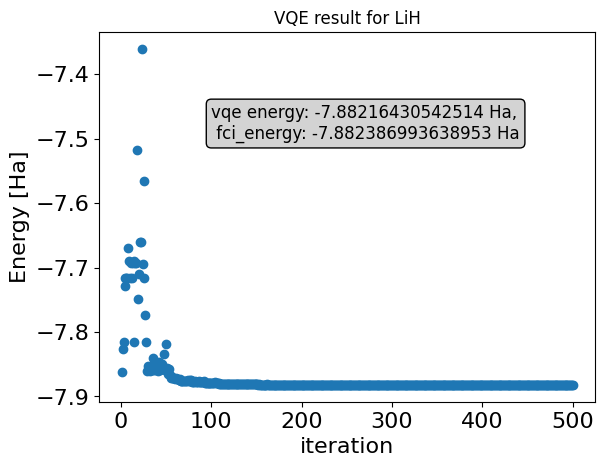

In [27]:
optimizer_res = res[0].value.energy
print(f"optimizer result classiq: {optimizer_res}")

vqe_results = {
    intermediate_result.iteration_number: intermediate_result.mean_all_solutions
    for intermediate_result in res[0].value.intermediate_results
}


plt.plot(vqe_results.keys(), vqe_results.values(), "o")
plt.ylabel("Energy [Ha]", fontsize=16)
plt.xlabel("iteration", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title("VQE result for " + description)
plt.text(
    100,
    -7.5,
    f"vqe energy: {optimizer_res} Ha,\n fci_energy: {molecule.fci_energy} Ha",
    fontsize=12,
    bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round,pad=0.3"),
);

## Appendix - generic approach for finding $\mathbb{Z}_2$ symmetries 

Below we provide some classical functions for finding symmetry generators for a given Hamiltonian, and the corresponding Pauli $X$ operators. The code is based on the algorithm provided in Ref. [[3](#sym1)] (see also Ref. [[4](#sym2)]). The theory behind the algorithm is described here in some detail. We provide a unified function `find_z2_symmetries`, that accepts a Hamiltonian and returns generators and $X$ operators.

### Moving to (x,z) representation

The convenient framework for finding $\mathbb{Z}_2$ symmetries is the $(x,z)$ representation of Pauli strings. In this representation we map a Pauli matrix to two binaries, $\sigma \rightarrow (a_x, a_z)$, according to 
$$
I\rightarrow (0,0),\quad Z\rightarrow (0,1),\quad X\rightarrow (1,0),\quad Y\rightarrow (1,1),
$$
and a Pauli string on $N$ qubits $\vec{\sigma}$ is mapped to $2N$ binary vector $(\vec{a}_x, \vec{a}_z)$. We have that two Pauli strings, $(\vec{a}_x, \vec{a}_z)$ and $(\vec{b}_x, \vec{b}_z)$, commutes, if $\vec{a}_x \vec{b}_z + \vec{a}_z \vec{b}_x = 0 \,\bmod{2}$. Thus, we can find the symmetry generators of an Hamiltonian by the following procedure:

1. Construct a binary matrix for the  Hamiltonian. A Hamiltonian with $r$ terms on $N$ qubits corresponds to $r\times 2N$ binary matrix.
2. Find the kernel (null space) of this matrix (by a Guass elimination). Then, each kernel vector $(g_z,g_x)$ (note the switch in $x,z$ positions) correspond to a Pauli string that commutes with all the Hamiltonian elements.
3. For the $X$ operators, a simple procedure can be carried on within the $(x,z)$ representation.


As a preliminary step, we start with two functions, transforming between operator and $(x,z)$ representations:

In [28]:
import numpy as np

bin_to_op = {(0, 1): "Z", (1, 1): "Y", (1, 0): "X"}


def pauli_to_xz(qubit_op: QubitOperator, n_qubits: int):
    """
    Convert a single Pauli string of size n_qubits (QubitOperator of length 1) to its (x,z) bits.
    """

    if len(qubit_op.terms) != 1:
        raise ValueError(
            "Expected a single-term QubitOperator for a Z2 symmetry generator."
        )

    ((pauli_term, coeff),) = qubit_op.terms.items()

    # Initialize bits
    x_bits = [0] * n_qubits
    z_bits = [0] * n_qubits
    if abs(coeff) < 1e-14:
        # Then it's effectively identity or zero operator
        # Just return identity bits
        return x_bits, z_bits

    for qubit_idx, pauli_str in pauli_term:
        if pauli_str == "X":
            x_bits[qubit_idx] = 1
            z_bits[qubit_idx] = 0
        elif pauli_str == "Y":
            x_bits[qubit_idx] = 1
            z_bits[qubit_idx] = 1
        elif pauli_str == "Z":
            x_bits[qubit_idx] = 0
            z_bits[qubit_idx] = 1

    return x_bits, z_bits


def qubit_op_to_xz(qubit_op: QubitOperator, n_qubits: int):
    """
    Return an ndarray of shape (len(qubit_op), 2*n_qubits), each row is (x_bits|z_bits).
    """
    op_size = len(qubit_op.terms)
    binary_mat = np.zeros((op_size, 2 * n_qubits), dtype=int)

    for row, term in enumerate(qubit_op):
        x_bits, z_bits = pauli_to_xz(term, n_qubits)
        # Fill the row
        # We put x_bits in columns [0..n_qubits-1], z_bits in columns [n_qubits..2*n_qubits-1]
        binary_mat[row, :n_qubits] = x_bits
        binary_mat[row, n_qubits:] = z_bits

    return binary_mat


def xz_to_opt(binary_matrix: np.ndarray):
    """
    Return an ndarray of shape (n_sym, 2*n_qubits), each row is (x_bits|z_bits).
    """
    binary_matrix = binary_matrix[
        ~np.all(binary_matrix == 0, axis=1)
    ]  # remove all-zero rows (Identity)
    qubit_op = QubitOperator()
    n_rows, n_cols = binary_matrix.shape
    n_qubits = n_cols // 2
    for raw in binary_matrix:
        op = [
            (i, bin_to_op[(raw[i], raw[n_qubits + i])])
            for i in range(n_qubits)
            if (raw[i], raw[n_qubits + i]) != (0, 0)
        ]
        qubit_op += QubitOperator(tuple(op), 1)

    return qubit_op

### Finding the null space for the Hamiltonian

The null space of the Hamiltonian in the $(x,z)$ representation can be found using two steps:

1. First, get the Reduced Row Echelon Form (RREF) of the matrix. In this form we have:
    * Every nonzero row has a leading 1.
    * Each leading 1 is the only nonzero entry in its column.
    * Rows of all zeros (if any) appear at the bottom of the matrix.
2. Then, in RREF it is easy to check and apply the null space equations.

In [29]:
def get_rref(binary_matrix):
    r"""Returns the reduced row echelon form (RREF) of a matrix over the binary finite field :math:`\mathbb{Z}_2`.

    Args:
        binary_matrix (np.ndarray): Binary matrix (dtype=int) to be reduced. Each entry should be 0 or 1.

    Returns:
        np.ndarray: The RREF of the given `binary_matrix` over :math:`\mathbb{Z}_2`.

    """
    # Make a copy, so we don't modify the original matrix.
    rref_binary_mat = binary_matrix.copy()
    shape = rref_binary_mat.shape
    n_rows, n_cols = shape
    icol = 0

    # Process each row.
    for irow in range(n_rows):
        # Find the pivot in the current row.
        while icol < n_cols and rref_binary_mat[irow, icol] == 0:
            # Look for a nonzero entry below in the same column.
            non_zero_idx = np.nonzero(rref_binary_mat[irow:, icol])[0]
            if len(non_zero_idx) == 0:
                # Entire column below is zero, move to next column.
                icol += 1
            else:
                # Swap the current row with the row containing the nonzero entry.
                krow = irow + non_zero_idx[0]
                rref_binary_mat[[irow, krow], icol:] = rref_binary_mat[
                    [krow, irow], icol:
                ].copy()
        # If we have a pivot, eliminate other 1s in the column.
        if icol < n_cols and rref_binary_mat[irow, icol] == 1:
            # Copy the pivot row's right-hand part.
            rpvt_cols = rref_binary_mat[irow, icol:].copy()
            # For all other rows, if they have a 1 in column icol, eliminate it by XORing.
            currcol = rref_binary_mat[:, icol].copy()
            currcol[irow] = 0  # Skip pivot row.
            # The XOR is implemented as addition mod 2.
            rref_binary_mat[:, icol:] ^= np.outer(currcol, rpvt_cols)
            icol += 1

    return rref_binary_mat.astype(int)


def kernel_from_rref(rref_mat):
    """
    Given a binary matrix in reduced row echelon form (RREF) over Z2,
    return a basis for its kernel (null space) as a NumPy array.

    Each row of the returned array is a kernel vector (a basis vector for the nullspace),
    with arithmetic done modulo 2.

    Args:
        rref_mat (np.ndarray): A binary matrix (dtype=int) in RREF over Z2 with shape (m, n).

    Returns:
        np.ndarray: A matrix of shape (n - rank, n) whose rows form a basis for the kernel.
    """

    # Remove all-zero rows
    rref_mat = rref_mat[~np.all(rref_mat == 0, axis=1)]
    m, n = rref_mat.shape

    # Identify pivot columns. For each row, the first nonzero entry (if any) is a pivot.
    pivots = []
    for i in range(m):
        row = rref_mat[i]
        nonzero = np.where(row == 1)[0]
        if nonzero.size > 0:
            pivots.append(nonzero[0])
    pivots = np.array(pivots)

    # The free (non-pivot) columns:
    free_cols = np.setdiff1d(np.arange(n), pivots)
    num_free = free_cols.size

    # We'll build a basis for the kernel.
    # For each free column, we set that free variable to 1 and the others to 0,
    # then solve for the pivot variables using the RREF equations.
    kernel_basis = np.zeros((num_free, n), dtype=int)

    # For each free variable, assign it the value 1.
    for i, free_col in enumerate(free_cols):
        kernel_basis[i, free_col] = 1

    # Now, for each pivot row in the RREF, the equation is:
    #    x[pivot] + sum_{j in free columns} (rref_mat[i, j] * x[j]) = 0  (mod 2)
    # So, for each pivot row, if rref_mat[i, free_col]==1, we must set x[pivot] = 1 in that basis vector.
    for i in range(m):
        # Find pivot column for this row (if any)
        nonzero = np.where(rref_mat[i] == 1)[0]
        if nonzero.size == 0:
            continue
        pivot_col = nonzero[0]
        # For every free column, if there is a 1 in that free column for the current row,
        # then the pivot variable must equal 1 (because 1+1 = 0 mod2).
        for basis_idx, free_col in enumerate(free_cols):
            if rref_mat[i, free_col] == 1:
                kernel_basis[basis_idx, pivot_col] = 1

    return kernel_basis

Now, we can define a function for obtaining the list of generators for a given Hamiltonian:

In [30]:
from typing import List


def get_z2symmetry_generators(qubit_op: QubitOperator, n_qubits: int):

    binary_mat = qubit_op_to_xz(qubit_op, n_qubits)
    kernel = kernel_from_rref(get_rref(binary_mat))
    kernel_zx = np.hstack(
        (kernel[:, n_qubits:], kernel[:, :n_qubits])
    )  # swaping x and z
    generators = []
    for raw in kernel_zx:
        generators.append(xz_to_opt(np.array([raw])))

    return generators

The $\left\{X_{m^{(i)}}\right\}$ operators can be found by a simple procedure, working in the $(x,z)$ representation. We construct the binary matrix for the list of generators, for $k$ generators we have a $k\times 2N$ binary matrix. Now, we need to find a set of $k$ binary vectors such that each vector $i$:
* Has a single 1 entry in the $m^{(i)}\in [0,N-1]$ positions, and all other entries are zero.
* It anticommutes with the $i$-th row of the binary matrix.
* It commutes with all the other rows.

Since we are working with a simple $\bmod 2$ arithmetics, this can be achieved by simple steps.

In [31]:
def get_xops_for_generators(generators: List[QubitOperator], n_qubits):

    kernel_xz = np.array([qubit_op_to_xz(gen, n_qubits)[0] for gen in generators])
    n_sym = len(generators)
    result_ops = [None] * n_sym
    for row_idx in range(n_sym):
        row_data = kernel_xz[row_idx]
        # separate x/z for this row
        x_row = row_data[:n_qubits]
        z_row = row_data[n_qubits:]

        # The rest
        rest_binary_mat = np.delete(kernel_xz, row_idx, axis=0)

        found_col = None
        for col in range(n_qubits):
            # We want this row to have z=1 => anticommute with X, i.e. z_row[col] should be 1
            # Then for all other rows, we want them to commute with X => z=0 means they commute
            if z_row[col] == 1:
                # Now check rest, they must have z=0 at 'col' (col + n_qubits as we look at the z part)
                z_part_rest = rest_binary_mat[:, n_qubits + col]
                if np.all(z_part_rest == 0):
                    found_col = col
                    break

        if found_col is not None:
            # Build QubitOperator for X on 'found_col'
            qop = QubitOperator(((found_col, "X"),), 1.0)
            result_ops[row_idx] = qop

    return result_ops

### Wrapping everything together

Finally, we define a single function that accepts a Hamiltonian and returns the symmetry generators and Pauli $X$ operators.

In [32]:
def find_z2sym(qubit_op: QubitOperator, n_qubits: int):
    generators = get_z2symmetry_generators(qubit_op, n_qubits)
    x_ops = get_xops_for_generators(generators, n_qubits)
    return generators, x_ops

In [33]:
generators, x_ops = find_z2sym(qubit_hamiltonian, n_qubits)
print(f"Found {len(generators)} Z2 symmetries:")
print(f"Generators: {generators}")
print(f"X operators: {x_ops}")

Found 4 Z2 symmetries:
Generators: [1.0 [Z4 Z5], 1.0 [Z6 Z7], 1.0 [Z0 Z2 Z4 Z6 Z8], 1.0 [Z1 Z3 Z4 Z6 Z9]]
X operators: [1.0 [X5], 1.0 [X7], 1.0 [X0], 1.0 [X1]]


## References

<a name='OF'>[1]</a>: [McClean et. al. Quantum Sci. Technol. 5 034014 (2020). OpenFermion: the electronic structure package for quantum computers.](https://arxiv.org/abs/1710.07629)

<a name='OFintro'>[2]</a>: [Introduction to OpenFermion.](https://quantumai.google/openfermion/tutorials/intro_to_openfermion)

<a name='sym1'>[3]</a>: [Bravyi et. al., arXiv preprint arXiv:1701.08213 (2017). Tapering off qubits to simulate fermionic Hamiltonians.
](https://arxiv.org/abs/1701.08213)

<a name='sym2'>[4]</a>: [Kanav et al. J. Chem. Theo. Comp. 16 10 (2020). Reducing qubit requirements for quantum simulations using molecular point group symmetries.](https://arxiv.org/abs/1910.14644)
